Using device: mps
Classes: ['benign', 'malignant']


/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma-env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma-env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


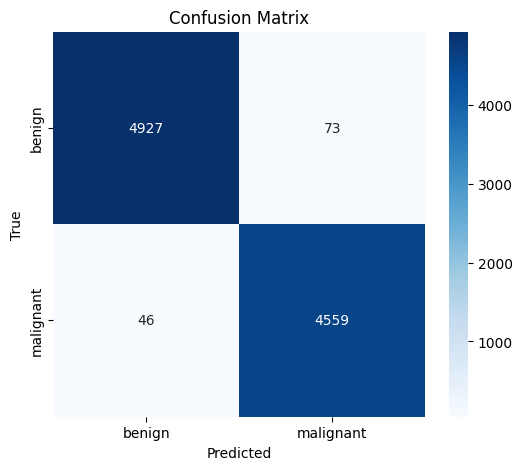


Classification Report:
              precision    recall  f1-score   support

      benign       0.99      0.99      0.99      5000
   malignant       0.98      0.99      0.99      4605

    accuracy                           0.99      9605
   macro avg       0.99      0.99      0.99      9605
weighted avg       0.99      0.99      0.99      9605


✅ Results exported to: /Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/results.json


In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# === CONFIG ===
VALIDATION_DIR = '/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/data/validation/train'
MODEL_PATH = '/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma_model.pth'
BATCH_SIZE = 32
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# === TRANSFORMS ===
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === LOAD DATA ===
test_dataset = datasets.ImageFolder(VALIDATION_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = test_dataset.classes  # ['benign', 'malignant']
print(f"Classes: {class_names}")

# === LOAD MODEL ===
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, len(class_names))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# === EVALUATION ===
all_preds = []
all_labels = []
all_confs = []
all_paths = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_confs.extend(confs.cpu().numpy())

# === CONFUSION MATRIX ===
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# === CLASSIFICATION REPORT ===
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# === EXPORT RESULTS TO JSON ===
results = []
for i in range(len(all_preds)):
    results.append({
        "true_label": class_names[all_labels[i]],
        "predicted_label": class_names[all_preds[i]],
        "confidence": float(all_confs[i])
    })

output_path = os.path.join(os.getcwd(), "results.json")
with open(output_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"\n✅ Results exported to: {output_path}")

Using device: mps
✅ Model loaded successfully!
Validation classes: ['benign', 'malignant']
Confusion Matrix:
[[4946   54]
 [1438 3167]]


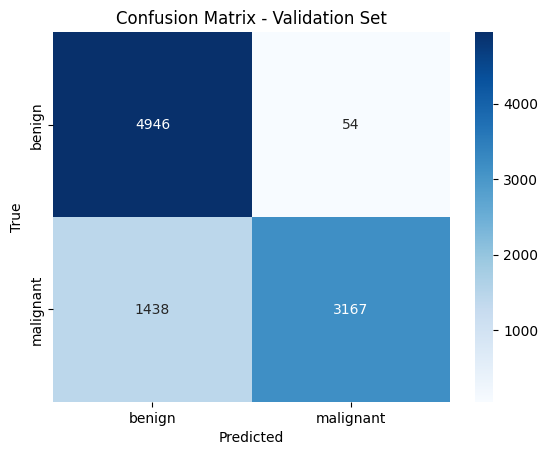


Classification Report:
              precision    recall  f1-score   support

      benign       0.77      0.99      0.87      5000
   malignant       0.98      0.69      0.81      4605

    accuracy                           0.84      9605
   macro avg       0.88      0.84      0.84      9605
weighted avg       0.87      0.84      0.84      9605

✅ Results exported to: /Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/validation_results.json


In [2]:
# ===========================
# 1️⃣ IMPORTS & CONFIG
# ===========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

# Use same device logic as before
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")
print(f"Using device: {device}")


VALIDATION_DIR = '/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/data/validation/train'
MODEL_PATH = '/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma_model2.pth'
BATCH_SIZE = 32

# ===========================
# 2️⃣ DEFINE THE SAME MODEL
# ===========================
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.drop4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.drop3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.drop4(x)
        logits = self.fc2(x)
        return logits

# ===========================
# 3️⃣ LOAD MODEL
# ===========================
model = CustomCNN(num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print("✅ Model loaded successfully!")

# ===========================
# 4️⃣ LOAD VALIDATION DATA
# ===========================
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder(VALIDATION_DIR, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
class_names = val_dataset.classes
print(f"Validation classes: {class_names}")

# ===========================
# 5️⃣ EVALUATION
# ===========================
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]  # malignant prob
        preds = (probs > 0.5).long()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# ===========================
# 6️⃣ METRICS
# ===========================
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ===========================
# 7️⃣ EXPORT RESULTS TO JSON
# ===========================
results = []
for true, pred, prob in zip(all_labels, all_preds, all_probs):
    results.append({
        "true_label": class_names[true],
        "predicted_label": class_names[pred],
        "confidence": float(prob)
    })

output_path = os.path.join(os.getcwd(), "validation_results.json")
with open(output_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"✅ Results exported to: {output_path}")